<a href="https://colab.research.google.com/github/farahqotrunnada/DTI/blob/main/Natural%20Language%20Processing/Hate_Speech_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [ ]:
! pip install wordcloud

In [ ]:
! pip install Sastrawi

In [ ]:
! pip install googletrans

In [ ]:
! pip install nltk

In [ ]:
nltk.download('stopwords')

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import pytz 
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import ast
import string
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder # to convert classes to number 
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
pd.set_option('max_colwidth',None)
df = pd.read_csv('https://raw.githubusercontent.com/farahqotrunnada/DTI/main/Natural%20Language%20Processing/IDHSD_RIO_unbalanced_713_2017.txt', sep='\t', encoding = "ISO-8859-1", dtype=str)
df

,Label,Tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera Menonaktifkan Ahok Jadi Gubernur DKI https:\/\/t.co\/KH5vIRwPdO
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi dalam rangka memenjarakan Ahok atau Ahok gagal dalam Pilkada.
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan perempuan? Buktinya banyak ibu2 mau foto bareng #DebatFinalPilkadaJKT
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Jalan di Bekasi Belum Sempat Terungkap https:\/\/t.co\/m3HopPLUID\u2026"
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal PILKADA https:\/\/t.co\/OOoERQV4SM
...,...,...
708,HS,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai....@basuki_btp...
709,HS,"Betul bang hancurkan merka bang, musnahkan china babi dibumi pertiwi indonesia, berkedok reklamasi itu ahok"
710,HS,"Sapa Yg bilang Ahok anti korupsi!?, klo grombolannyA NGOMONG gtu wajar, AHOK ITU MAFIA KORUPTOR SANG PENISTA AGAMA YG DILINDUNGI ISTANA PKI"
711,HS,"Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar Pcetar, langsung kejang2 die, ngadu ke Jkw, Jkw: makanye sunat dulu, bru NGOMONG Almaidah."


Text(0.5, 1.0, 'Count')

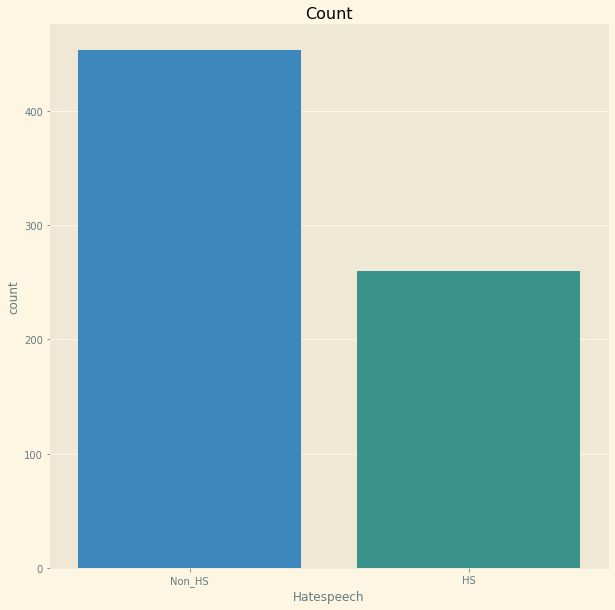

In [ ]:
# Analysis label balancing
sns.countplot(df.Label)
plt.xlabel('Hatespeech')
plt.title('Count')

# Preprocessing

## 1. Emoji, Punctuation, Number and Symbol Handling

In [ ]:
def emoji_handling(review):
    emoji = []
    for word in review:
        #Smile -- :), : ), :-), (:, ( :, (-:, :')
        word = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))','POS',word)
        
        #Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
        word = re.sub(r'(:\s?D|:-D|x-?D|X-?D)','POS',word)

        # Sad -- :-(, : (, :(, ):, )-:
        word = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' NEG ', word)

        # Cry -- :,(, :'(, :"(, T_T
        word = re.sub(r'(:,\(|:\'\(|:"\(|T_T)', ' NEG ', word)

        emoji.append(word)
    return emoji

In [ ]:
def pre(review):
    #menghilangkan tanda baca
    preprocess_review = []
    for word in review:
        word = word.strip('\'"?!,.():;')

        #mengkonversi huruf vocal lebih dari satu dan berurutan
        word_character = re.compile(r"(.)\1+", re.DOTALL)
        word = word_character.sub(r"\1\1", word)

        #menghilangkan tanda baca
        word = word.translate(str.maketrans('','',string.punctuation)).lower()
   
        # Remove number
        word = re.sub('\d+', '',word)
        
        # Remove Twitter Post Link and RT word
        word = re.sub(r'(http\S+)', '',word)
        word = re.sub(r'(www\S+)', '', word)
        word = re.sub(r'(rt)', '',word)
        
        preprocess_review.append(word)
    return preprocess_review

In [ ]:
def preprocess(review):
    return pre(emoji_handling(review))

## 2. Stemming

In [ ]:
def stem_sentences(review):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(review)

## 3. Stopwords Removal

In [ ]:
#augment the indonesia+english stopwords with nonstandard twitter words
stopwords_eng = set(stopwords.words('english'))
stopwords_set = set(stopwords.words("indonesian"))
stopwords_aug = {"ya","yak","iya","yg","ga","gak","gk","udh","sdh","udah","dah","nih","ini","deh","sih","dong","donk",
                 "sm","knp","utk","yaa","tdk","gini","gitu","bgt","gt","nya","kalo","cb","jg","jgn","gw","ge",
                 "sy","min","mas","mba","mbak","pak","kak","trus","trs","bs","bisa","aja","saja","no",
                 "w","g","gua","gue","emang","emg","wkwk","dr","kau","dg","gimana","apapun","apa",
                 "klo","yah","banget","pake","terus","krn","jadi","jd","mu","ku","si","hehe",
                 "tp","pa","lu","lo","lw","tw","tau","karna","kayak","ky","lg","untuk","tuk","dg","dgn","loh","tuh","biar","jakaa"}
stopwords_a = stopwords_set.union(stopwords_aug)
stopwords_all=stopwords_eng.union(stopwords_a)

## 4. Execution

In [ ]:
#Preprocessing
df["Tweet"] = preprocess(df["Tweet"])

#Tokenize
df["Tweet"] = df["Tweet"].apply(nltk.word_tokenize)

#Stopwords Removal
df["Tweet"] = df["Tweet"].apply(lambda x: [item for item in x if item not in stopwords_all])

#Stemming
df["Tweet"] = df["Tweet"].apply(lambda x: [stem_sentences(item) for item in x])

# Word Cloud Hate Speech

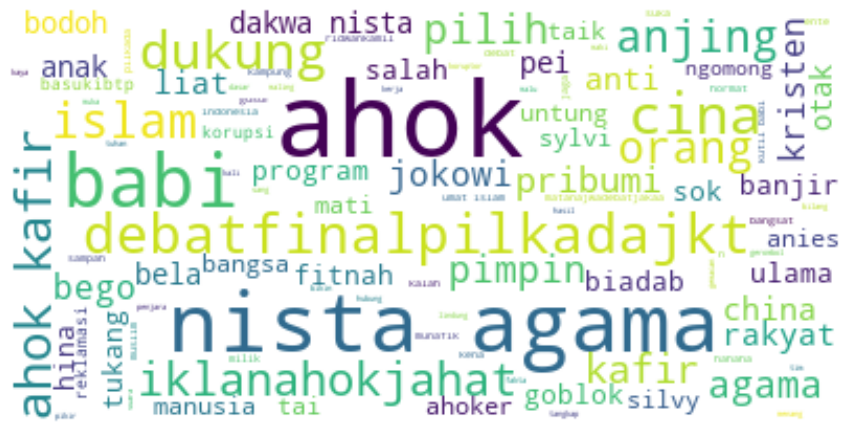

In [ ]:
w_hate = df.Tweet[df['Label']=='HS'].astype('str').str.replace("'","")
w_hate.head()
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_text(' '.join(w_hate))

# Display the generated image:
plt.figure(figsize = (15, 15)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Vectorization with TF-IDF

In [ ]:
target = LabelEncoder().fit_transform(df['Label'])
Tfidf_vect = TfidfVectorizer(tokenizer=lambda x: x,preprocessor=lambda x: x)
feature=Tfidf_vect.fit_transform(df['Tweet'])
feature = pd.DataFrame(feature.toarray(),columns=Tfidf_vect.get_feature_names())

# Splitting to train-test set

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(feature , target, shuffle = True, test_size=0.18, random_state=1)

# Show the Training and Testing Data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(584, 2263)
(129, 2263)
(584,)
(129,)


# Modelling with Several Models

In [ ]:
mplc=MLPClassifier(alpha=1)
log_reg = LogisticRegression()
svm = SVC(kernel='rbf', probability=True)
dec_tree = DecisionTreeClassifier(min_impurity_decrease=0.01)
gau_nb = GaussianNB(var_smoothing=0.0001)
rfc = RandomForestClassifier(n_estimators=150)
knn = KNeighborsClassifier(n_neighbors=5)
grad_bos = GradientBoostingClassifier()

In [ ]:
mplc.fit(X_train, y_train)
svm.fit(X_train, y_train)
rfc.fit(X_train, y_train)
knn.fit(X_train, y_train)
dec_tree.fit(X_train, y_train)
gau_nb.fit(X_train, y_train)
log_reg.fit(X_train, y_train)
grad_bos.fit(X_train, y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GradientBoostingClassifier()

In [ ]:
# Cross-Validation for avoiding overfitting

from sklearn.model_selection import cross_val_score

cv = 5
print(f'CV Score of mplc : {cross_val_score(mplc, X_train, y_train, cv=cv, n_jobs=-1).mean()}')
print(f'CV Score of SVM : {cross_val_score(svm, X_train, y_train, cv=cv, n_jobs=-1).mean()}')
print(f'CV Score of RFC: {cross_val_score(rfc, X_train, y_train, cv=cv, n_jobs=-1).mean()}')
print(f'CV Score of KNN : {cross_val_score(knn, X_train, y_train, cv=cv, n_jobs=-1).mean()}')
print(f'CV Score of Decision Tree : {cross_val_score(dec_tree, X_train, y_train, cv=cv, n_jobs=-1).mean()}')
print(f'CV Score of Gaussian Nb : {cross_val_score(gau_nb, X_train, y_train,cv=cv, n_jobs=-1).mean()}')
print(f'CV Score of LogReg : {cross_val_score(log_reg, X_train, y_train, cv=cv, n_jobs=-1).mean()}')
print(f'CV Score of Grad_Bos : {cross_val_score(grad_bos, X_train, y_train, cv=cv, n_jobs=-1).mean()}')

CV Score of mplc : 0.835632183908046
CV Score of SVM : 0.79447391688771
CV Score of RFC: 0.8270114942528736
CV Score of KNN : 0.8218980253463013
CV Score of Decision Tree : 0.8150604185086945
CV Score of Gaussian Nb : 0.7379899793692897
CV Score of LogReg : 0.7653993516062482
CV Score of Grad_Bos : 0.8253020925434719


**Model Evaluation**

In [ ]:
from sklearn.metrics import precision_score, recall_score, cohen_kappa_score,classification_report, f1_score, accuracy_score,confusion_matrix
y_pred_mplc = mplc.predict(X_test)
y_pred_svm = svm.predict(X_test)
y_pred_rfc = rfc.predict(X_test)
y_pred_knn = knn.predict(X_test)
y_pred_dec_tree = dec_tree.predict(X_test)
y_pred_gau_nb = gau_nb.predict(X_test)
y_pred_log_reg = log_reg.predict(X_test)
y_pred_grad_bos = grad_bos.predict(X_test)

In [ ]:
# Show the Confussion Matrix
print('mplc')
display(confusion_matrix(y_test, y_pred_mplc))
print('SVM')
display(confusion_matrix(y_test, y_pred_svm))
print('RFC')
display(confusion_matrix(y_test, y_pred_rfc))
print('KNN')
display(confusion_matrix(y_test, y_pred_knn))
print('Decision Tree')
display(confusion_matrix(y_test, y_pred_dec_tree))
print('Gaussian Nb')
display(confusion_matrix(y_test, y_pred_gau_nb))
print('Logistic Regression')
display(confusion_matrix(y_test, y_pred_log_reg))
print('Gradient Boosting')
display(confusion_matrix(y_test, y_pred_grad_bos))

mplc


array([[35, 14],
       [ 4, 76]], dtype=int64)

SVM


array([[30, 19],
       [ 3, 77]], dtype=int64)

RFC


array([[34, 15],
       [ 4, 76]], dtype=int64)

KNN


array([[33, 16],
       [ 8, 72]], dtype=int64)

Decision Tree


array([[33, 16],
       [ 4, 76]], dtype=int64)

Gaussian Nb


array([[36, 13],
       [24, 56]], dtype=int64)

Logistic Regression


array([[30, 19],
       [ 3, 77]], dtype=int64)

Gradient Boosting


array([[34, 15],
       [ 5, 75]], dtype=int64)

In [ ]:
print('Accuracy score')
print(f'mplc : {accuracy_score(y_test, y_pred_mplc)}')
print(f'SVM : {accuracy_score(y_test, y_pred_svm)}')
print(f'RFC: {accuracy_score(y_test, y_pred_rfc)}')
print(f'KNN : {accuracy_score(y_test, y_pred_knn)}')
print(f'Decision Tree : {accuracy_score(y_test, y_pred_dec_tree)}')
print(f'Gaussian Nb : {accuracy_score(y_test, y_pred_gau_nb)}')
print(f'LogReg  : {accuracy_score(y_test, y_pred_log_reg)}')
print(f'Grad_Bos : {accuracy_score(y_test, y_pred_grad_bos)}')
print('\n')

print('Precision score')
print(f'mplc : {precision_score(y_test, y_pred_mplc)}')
print(f'SVM : {precision_score(y_test, y_pred_svm)}')
print(f'RFC: {precision_score(y_test, y_pred_rfc)}')
print(f'KNN : {precision_score(y_test, y_pred_knn)}')
print(f'Decision Tree : {precision_score(y_test, y_pred_dec_tree)}')
print(f'Gaussian Nb : {precision_score(y_test, y_pred_gau_nb)}')
print(f'LogReg  : {precision_score(y_test, y_pred_log_reg)}')
print(f'Grad_Bos : {precision_score(y_test, y_pred_grad_bos)}')
print('\n')

print('recall_score')
print(f'mplc : {recall_score(y_test, y_pred_mplc)}')
print(f'SVM : {recall_score(y_test, y_pred_svm)}')
print(f'RFC: {recall_score(y_test, y_pred_rfc)}')
print(f'KNN : {recall_score(y_test, y_pred_knn)}')
print(f'Decision Tree : {recall_score(y_test, y_pred_dec_tree)}')
print(f'Gaussian Nb : {recall_score(y_test, y_pred_gau_nb)}')
print(f'LogReg  : {recall_score(y_test, y_pred_log_reg)}')
print(f'Grad_Bos : {recall_score(y_test, y_pred_grad_bos)}')
print('\n')

print('cohen_kappa_score')
print(f'mplc : {cohen_kappa_score(y_test, y_pred_mplc)}')
print(f'SVM : {cohen_kappa_score(y_test, y_pred_svm)}')
print(f'RFC: {cohen_kappa_score(y_test, y_pred_rfc)}')
print(f'KNN : {cohen_kappa_score(y_test, y_pred_knn)}')
print(f'Decision Tree : {cohen_kappa_score(y_test, y_pred_dec_tree)}')
print(f'Gaussian Nb : {cohen_kappa_score(y_test, y_pred_gau_nb)}')
print(f'LogReg  : {cohen_kappa_score(y_test, y_pred_log_reg)}')
print(f'Grad_Bos : {cohen_kappa_score(y_test, y_pred_grad_bos)}')
print('\n')

print('F-Score')
print(f'mplc : {f1_score(y_test, y_pred_mplc)}')
print(f'SVM : {f1_score(y_test, y_pred_svm)}')
print(f'RFC: {f1_score(y_test, y_pred_rfc)}')
print(f'KNN : {f1_score(y_test, y_pred_knn)}')
print(f'Decision Tree : {f1_score(y_test, y_pred_dec_tree)}')
print(f'Gaussian Nb : {f1_score(y_test, y_pred_gau_nb)}')
print(f'LogReg  : {f1_score(y_test, y_pred_log_reg)}')
print(f'Grad_Bos : {f1_score(y_test, y_pred_grad_bos)}')

Accuracy score
mplc : 0.8604651162790697
SVM : 0.8294573643410853
RFC: 0.8527131782945736
KNN : 0.813953488372093
Decision Tree : 0.8449612403100775
Gaussian Nb : 0.7131782945736435
LogReg  : 0.8294573643410853
Grad_Bos : 0.8449612403100775


Precision score
mplc : 0.8444444444444444
SVM : 0.8020833333333334
RFC: 0.8351648351648352
KNN : 0.8181818181818182
Decision Tree : 0.8260869565217391
Gaussian Nb : 0.8115942028985508
LogReg  : 0.8020833333333334
Grad_Bos : 0.8333333333333334


recall_score
mplc : 0.95
SVM : 0.9625
RFC: 0.95
KNN : 0.9
Decision Tree : 0.95
Gaussian Nb : 0.7
LogReg  : 0.9625
Grad_Bos : 0.9375


cohen_kappa_score
mplc : 0.6916334661354582
SVM : 0.613562091503268
RFC: 0.6731564208561142
KNN : 0.5922023182297156
Decision Tree : 0.6545259775040171
Gaussian Nb : 0.41657499083241667
LogReg  : 0.613562091503268
Grad_Bos : 0.6573705179282869


F-Score
mplc : 0.8941176470588236
SVM : 0.8750000000000001
RFC: 0.888888888888889
KNN : 0.8571428571428572
Decision Tree : 0.8837209

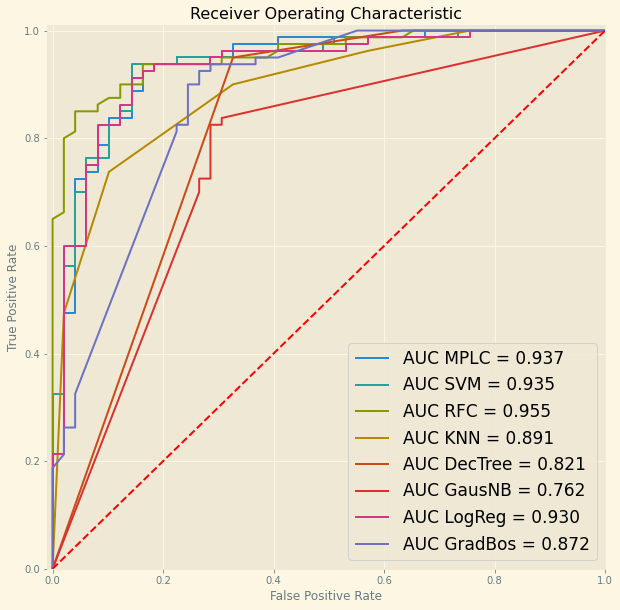

In [ ]:
from sklearn import metrics
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('Solarize_Light2')

y_pred_mplc_proba = mplc.predict_proba(X_test)
y_pred_svm_proba = svm.predict_proba(X_test)
y_pred_rfc_proba = rfc.predict_proba(X_test)
y_pred_knn_proba = knn.predict_proba(X_test)
y_pred_dec_tree_proba = dec_tree.predict_proba(X_test)
y_pred_gau_nb_proba = gau_nb.predict_proba(X_test)
y_pred_log_reg_proba = log_reg.predict_proba(X_test)
y_pred_grad_bos_proba = grad_bos.predict_proba(X_test)

y_preds_mplc = y_pred_mplc_proba[:,1]
y_preds_svm = y_pred_svm_proba[:,1]
y_preds_rfc = y_pred_rfc_proba[:,1]
y_preds_knn = y_pred_knn_proba[:,1]
y_preds_dectree = y_pred_dec_tree_proba[:,1]
y_preds_gaunb = y_pred_gau_nb_proba[:,1]
y_preds_logreg = y_pred_log_reg_proba[:,1]
y_preds_gradbos = y_pred_grad_bos_proba[:,1]

fpr_mplc, tpr_mplc, threshold_mplc = metrics.roc_curve(y_test, y_preds_mplc)
roc_auc_mplc = metrics.auc(fpr_mplc, tpr_mplc)
fpr_svm, tpr_svm, threshold_svm = metrics.roc_curve(y_test, y_preds_svm)
roc_auc_svm = metrics.auc(fpr_svm, tpr_svm)
fpr_rfc, tpr_rfc, threshold = metrics.roc_curve(y_test, y_preds_rfc)
roc_auc_rfc = metrics.auc(fpr_rfc, tpr_rfc)
fpr_knn, tpr_knn, threshold = metrics.roc_curve(y_test, y_preds_knn)
roc_auc_knn = metrics.auc(fpr_knn, tpr_knn)
fpr_dectree, tpr_dectree, threshold = metrics.roc_curve(y_test, y_preds_dectree)
roc_auc_dectree = metrics.auc(fpr_dectree, tpr_dectree)
fpr_gaunb, tpr_gaunb, threshold = metrics.roc_curve(y_test, y_preds_gaunb)
roc_auc_gaunb = metrics.auc(fpr_gaunb, tpr_gaunb)
fpr_logreg, tpr_logreg, threshold = metrics.roc_curve(y_test, y_preds_logreg)
roc_auc_logreg = metrics.auc(fpr_logreg, tpr_logreg)
fpr_gradbos, tpr_gradbos, threshold = metrics.roc_curve(y_test, y_preds_gradbos)
roc_auc_grabos = metrics.auc(fpr_gradbos, tpr_gradbos)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_mplc, tpr_mplc, label = 'AUC MPLC = %0.3f' % roc_auc_mplc)
plt.plot(fpr_svm, tpr_svm, label = 'AUC SVM = %0.3f' % roc_auc_svm)
plt.plot(fpr_rfc, tpr_rfc, label = 'AUC RFC = %0.3f' % roc_auc_rfc)
plt.plot(fpr_knn, tpr_knn, label = 'AUC KNN = %0.3f' % roc_auc_knn)
plt.plot(fpr_dectree, tpr_dectree, label = 'AUC DecTree = %0.3f' % roc_auc_dectree)
plt.plot(fpr_gaunb, tpr_gaunb, label = 'AUC GausNB = %0.3f' % roc_auc_gaunb)
plt.plot(fpr_logreg, tpr_logreg, label = 'AUC LogReg = %0.3f' % roc_auc_logreg)
plt.plot(fpr_gradbos, tpr_gradbos, label = 'AUC GradBos = %0.3f' % roc_auc_grabos)

plt.legend(loc = 4,prop={'size': 17})
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Modelling with SMOTE (Handling Imbalanced Label)

In [ ]:
from imblearn.over_sampling import SMOTE

# Separate input features and target
y = target
X = feature

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=27)

sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)

In [ ]:
mplc.fit(X_train, y_train)
svm.fit(X_train, y_train)
rfc.fit(X_train, y_train)
knn.fit(X_train, y_train)
dec_tree.fit(X_train, y_train)
gau_nb.fit(X_train, y_train)
log_reg.fit(X_train, y_train)
grad_bos.fit(X_train, y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GradientBoostingClassifier()

In [ ]:
# Cross-Validation for avoiding overfitting

from sklearn.model_selection import cross_val_score

cv = 5
print(f'CV Score of mplc : {cross_val_score(mplc, X_train, y_train, cv=cv, n_jobs=-1).mean()}')
print(f'CV Score of SVM : {cross_val_score(svm, X_train, y_train, cv=cv, n_jobs=-1).mean()}')
print(f'CV Score of RFC: {cross_val_score(rfc, X_train, y_train, cv=cv, n_jobs=-1).mean()}')
print(f'CV Score of KNN : {cross_val_score(knn, X_train, y_train, cv=cv, n_jobs=-1).mean()}')
print(f'CV Score of Decision Tree : {cross_val_score(dec_tree, X_train, y_train, cv=cv, n_jobs=-1).mean()}')
print(f'CV Score of Gaussian Nb : {cross_val_score(gau_nb, X_train, y_train,cv=cv, n_jobs=-1).mean()}')
print(f'CV Score of LogReg : {cross_val_score(log_reg, X_train, y_train, cv=cv, n_jobs=-1).mean()}')
print(f'CV Score of Grad_Bos : {cross_val_score(grad_bos, X_train, y_train, cv=cv, n_jobs=-1).mean()}')

CV Score of mplc : 0.9208088714938031
CV Score of SVM : 0.8935979871400616
CV Score of RFC: 0.8867673096635915
CV Score of KNN : 0.5697232317584568
CV Score of Decision Tree : 0.8510949585313579
CV Score of Gaussian Nb : 0.8484950144441339
CV Score of LogReg : 0.9016867020780917
CV Score of Grad_Bos : 0.8703289534992079


**Model Evaluation**

In [ ]:
from sklearn.metrics import precision_score, recall_score, cohen_kappa_score,classification_report, f1_score, accuracy_score,confusion_matrix
y_pred_mplc = mplc.predict(X_test)
y_pred_svm = svm.predict(X_test)
y_pred_rfc = rfc.predict(X_test)
y_pred_knn = knn.predict(X_test)
y_pred_dec_tree = dec_tree.predict(X_test)
y_pred_gau_nb = gau_nb.predict(X_test)
y_pred_log_reg = log_reg.predict(X_test)
y_pred_grad_bos = grad_bos.predict(X_test)

In [ ]:
# Show the Confussion Matrix
print('mplc')
display(confusion_matrix(y_test, y_pred_mplc))
print('SVM')
display(confusion_matrix(y_test, y_pred_svm))
print('RFC')
display(confusion_matrix(y_test, y_pred_rfc))
print('KNN')
display(confusion_matrix(y_test, y_pred_knn))
print('Decision Tree')
display(confusion_matrix(y_test, y_pred_dec_tree))
print('Gaussian Nb')
display(confusion_matrix(y_test, y_pred_gau_nb))
print('Logistic Regression')
display(confusion_matrix(y_test, y_pred_log_reg))
print('Gradient Boosting')
display(confusion_matrix(y_test, y_pred_grad_bos))

mplc


array([[34,  8],
       [ 5, 82]], dtype=int64)

SVM


array([[29, 13],
       [ 2, 85]], dtype=int64)

RFC


array([[32, 10],
       [ 2, 85]], dtype=int64)

KNN


array([[42,  0],
       [66, 21]], dtype=int64)

Decision Tree


array([[29, 13],
       [ 5, 82]], dtype=int64)

Gaussian Nb


array([[36,  6],
       [28, 59]], dtype=int64)

Logistic Regression


array([[33,  9],
       [ 4, 83]], dtype=int64)

Gradient Boosting


array([[31, 11],
       [ 5, 82]], dtype=int64)

In [ ]:
print('Accuracy score')
print(f'mplc : {accuracy_score(y_test, y_pred_mplc)}')
print(f'SVM : {accuracy_score(y_test, y_pred_svm)}')
print(f'RFC: {accuracy_score(y_test, y_pred_rfc)}')
print(f'KNN : {accuracy_score(y_test, y_pred_knn)}')
print(f'Decision Tree : {accuracy_score(y_test, y_pred_dec_tree)}')
print(f'Gaussian Nb : {accuracy_score(y_test, y_pred_gau_nb)}')
print(f'LogReg  : {accuracy_score(y_test, y_pred_log_reg)}')
print(f'Grad_Bos : {accuracy_score(y_test, y_pred_grad_bos)}')
print('\n')

print('Precision score')
print(f'mplc : {precision_score(y_test, y_pred_mplc)}')
print(f'SVM : {precision_score(y_test, y_pred_svm)}')
print(f'RFC: {precision_score(y_test, y_pred_rfc)}')
print(f'KNN : {precision_score(y_test, y_pred_knn)}')
print(f'Decision Tree : {precision_score(y_test, y_pred_dec_tree)}')
print(f'Gaussian Nb : {precision_score(y_test, y_pred_gau_nb)}')
print(f'LogReg  : {precision_score(y_test, y_pred_log_reg)}')
print(f'Grad_Bos : {precision_score(y_test, y_pred_grad_bos)}')
print('\n')

print('recall_score')
print(f'mplc : {recall_score(y_test, y_pred_mplc)}')
print(f'SVM : {recall_score(y_test, y_pred_svm)}')
print(f'RFC: {recall_score(y_test, y_pred_rfc)}')
print(f'KNN : {recall_score(y_test, y_pred_knn)}')
print(f'Decision Tree : {recall_score(y_test, y_pred_dec_tree)}')
print(f'Gaussian Nb : {recall_score(y_test, y_pred_gau_nb)}')
print(f'LogReg  : {recall_score(y_test, y_pred_log_reg)}')
print(f'Grad_Bos : {recall_score(y_test, y_pred_grad_bos)}')
print('\n')

print('cohen_kappa_score')
print(f'mplc : {cohen_kappa_score(y_test, y_pred_mplc)}')
print(f'SVM : {cohen_kappa_score(y_test, y_pred_svm)}')
print(f'RFC: {cohen_kappa_score(y_test, y_pred_rfc)}')
print(f'KNN : {cohen_kappa_score(y_test, y_pred_knn)}')
print(f'Decision Tree : {cohen_kappa_score(y_test, y_pred_dec_tree)}')
print(f'Gaussian Nb : {cohen_kappa_score(y_test, y_pred_gau_nb)}')
print(f'LogReg  : {cohen_kappa_score(y_test, y_pred_log_reg)}')
print(f'Grad_Bos : {cohen_kappa_score(y_test, y_pred_grad_bos)}')
print('\n')

print('F-Score')
print(f'mplc : {f1_score(y_test, y_pred_mplc)}')
print(f'SVM : {f1_score(y_test, y_pred_svm)}')
print(f'RFC: {f1_score(y_test, y_pred_rfc)}')
print(f'KNN : {f1_score(y_test, y_pred_knn)}')
print(f'Decision Tree : {f1_score(y_test, y_pred_dec_tree)}')
print(f'Gaussian Nb : {f1_score(y_test, y_pred_gau_nb)}')
print(f'LogReg  : {f1_score(y_test, y_pred_log_reg)}')
print(f'Grad_Bos : {f1_score(y_test, y_pred_grad_bos)}')

Accuracy score
mplc : 0.8992248062015504
SVM : 0.8837209302325582
RFC: 0.9069767441860465
KNN : 0.4883720930232558
Decision Tree : 0.8604651162790697
Gaussian Nb : 0.7364341085271318
LogReg  : 0.8992248062015504
Grad_Bos : 0.875968992248062


Precision score
mplc : 0.9111111111111111
SVM : 0.8673469387755102
RFC: 0.8947368421052632
KNN : 1.0
Decision Tree : 0.8631578947368421
Gaussian Nb : 0.9076923076923077
LogReg  : 0.9021739130434783
Grad_Bos : 0.8817204301075269


recall_score
mplc : 0.9425287356321839
SVM : 0.9770114942528736
RFC: 0.9770114942528736
KNN : 0.2413793103448276
Decision Tree : 0.9425287356321839
Gaussian Nb : 0.6781609195402298
LogReg  : 0.9540229885057471
Grad_Bos : 0.9425287356321839


cohen_kappa_score
mplc : 0.76620660811376
SVM : 0.7159841479524438
RFC: 0.7772020725388601
KNN : 0.17162872154115572
Decision Tree : 0.6658031088082902
Gaussian Nb : 0.47143890093998553
LogReg  : 0.7632359169843287
Grad_Bos : 0.7067348678601876


F-Score
mplc : 0.9265536723163842
SVM 

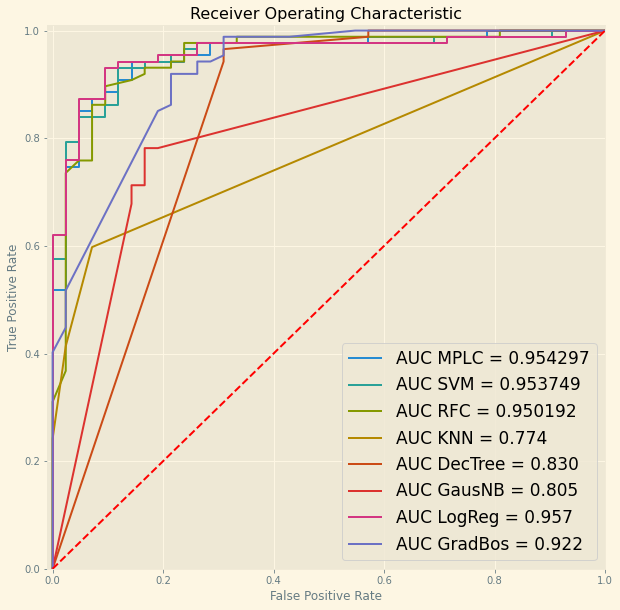

In [ ]:
from sklearn import metrics
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('Solarize_Light2')

y_pred_mplc_proba = mplc.predict_proba(X_test)
y_pred_svm_proba = svm.predict_proba(X_test)
y_pred_rfc_proba = rfc.predict_proba(X_test)
y_pred_knn_proba = knn.predict_proba(X_test)
y_pred_dec_tree_proba = dec_tree.predict_proba(X_test)
y_pred_gau_nb_proba = gau_nb.predict_proba(X_test)
y_pred_log_reg_proba = log_reg.predict_proba(X_test)
y_pred_grad_bos_proba = grad_bos.predict_proba(X_test)

y_preds_mplc = y_pred_mplc_proba[:,1]
y_preds_svm = y_pred_svm_proba[:,1]
y_preds_rfc = y_pred_rfc_proba[:,1]
y_preds_knn = y_pred_knn_proba[:,1]
y_preds_dectree = y_pred_dec_tree_proba[:,1]
y_preds_gaunb = y_pred_gau_nb_proba[:,1]
y_preds_logreg = y_pred_log_reg_proba[:,1]
y_preds_gradbos = y_pred_grad_bos_proba[:,1]

fpr_mplc, tpr_mplc, threshold_mplc = metrics.roc_curve(y_test, y_preds_mplc)
roc_auc_mplc = metrics.auc(fpr_mplc, tpr_mplc)
fpr_svm, tpr_svm, threshold_svm = metrics.roc_curve(y_test, y_preds_svm)
roc_auc_svm = metrics.auc(fpr_svm, tpr_svm)
fpr_rfc, tpr_rfc, threshold = metrics.roc_curve(y_test, y_preds_rfc)
roc_auc_rfc = metrics.auc(fpr_rfc, tpr_rfc)
fpr_knn, tpr_knn, threshold = metrics.roc_curve(y_test, y_preds_knn)
roc_auc_knn = metrics.auc(fpr_knn, tpr_knn)
fpr_dectree, tpr_dectree, threshold = metrics.roc_curve(y_test, y_preds_dectree)
roc_auc_dectree = metrics.auc(fpr_dectree, tpr_dectree)
fpr_gaunb, tpr_gaunb, threshold = metrics.roc_curve(y_test, y_preds_gaunb)
roc_auc_gaunb = metrics.auc(fpr_gaunb, tpr_gaunb)
fpr_logreg, tpr_logreg, threshold = metrics.roc_curve(y_test, y_preds_logreg)
roc_auc_logreg = metrics.auc(fpr_logreg, tpr_logreg)
fpr_gradbos, tpr_gradbos, threshold = metrics.roc_curve(y_test, y_preds_gradbos)
roc_auc_grabos = metrics.auc(fpr_gradbos, tpr_gradbos)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_mplc, tpr_mplc, label = 'AUC MPLC = %f' % roc_auc_mplc)
plt.plot(fpr_svm, tpr_svm, label = 'AUC SVM = %f' % roc_auc_svm)
plt.plot(fpr_rfc, tpr_rfc, label = 'AUC RFC = %f' % roc_auc_rfc)
plt.plot(fpr_knn, tpr_knn, label = 'AUC KNN = %0.3f' % roc_auc_knn)
plt.plot(fpr_dectree, tpr_dectree, label = 'AUC DecTree = %0.3f' % roc_auc_dectree)
plt.plot(fpr_gaunb, tpr_gaunb, label = 'AUC GausNB = %0.3f' % roc_auc_gaunb)
plt.plot(fpr_logreg, tpr_logreg, label = 'AUC LogReg = %0.3f' % roc_auc_logreg)
plt.plot(fpr_gradbos, tpr_gradbos, label = 'AUC GradBos = %0.3f' % roc_auc_grabos)

plt.legend(loc = 4,prop={'size': 17})
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Summary

-The best accuracy score is achieved by model that handling imbalanced label that is Random Forest (0.9069767441860465), then Multi-layer Perceptron classifier (0.8992248062015504), and Logistic Regression (0.8992248062015504) with high score of precision, recall, even AUC. Therefore, this high accuracy score is not bias. Moreover, the Cross-Validation Score is high too, so the model is not overfitting. 

-The most common word in hate-speech can be seen in wordcloud